In [ ]:
!pip install hmmlearn

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Import HMM model
file_id = '1g1oFUsiGewS48FEjK_fSsBxrPGKAZqr2'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('HMM_model.pkl')

# Import predicted states for 2-state model
file_id = '1GkgdECPAE6IYo--HqNNktBROd6Jd73ww'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('2-state predictions.csv')

# Asset classes
file_id = '1MiP5SOVOAYp2dfS9jyc8ETIyIbLp-1K4'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Asset Classes.xlsx')

# New 3M bill
file_id = '1y82lxkcwWPUXc8nCOUVTiVkxh8hJt1AB'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('3M.xlsx')


In [1]:
 import warnings
warnings.filterwarnings("ignore")

#import packages for use later in the HMM code
from hmmlearn import hmm
import pandas as pd; pd.set_option('precision', 10)
import numpy as np; np.set_printoptions(precision=10, suppress=True)
from scipy import stats

import matplotlib.pyplot as plt
fontsize = 15 # Set fontsize for all figures
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

import scipy.optimize as opt
import datetime as dt
import pickle

def printf(text, value, pct=False):
    if pct == True:
        print(text, f"{value*100:.8f}%")
    else:
        print(text, f"{value:.8f}")

# Load and visualize data

In [5]:
# Load HMM model
#with open("HMM_model.pkl", "rb") as file: model = pickle.load(file)

# Train/test periods - NB! REMEMBER TO CHECK THIS IS THE SAME AS IN HMM MODEL.
start_train = '2015-05-19'
end_train = '2020-05-19'
start_test = '2015-01-02'
end_test = '2020-05-19'

##### LOAD DATAFRAMES: PREDICTED STATES, FACTOR PRICES AND RISK-FREE RATES ######################
df = pd.read_csv("2-state predictions.csv", index_col="Date").drop("MSCI ACWI", axis=1).loc[start_train:end_test]
index_data = pd.read_excel('Asset Classes.xlsx', index_col="Date")
df_rf = pd.read_excel('3M.xlsx', index_col="Date") / 100


df = pd.merge(df, index_data, how="left",
        left_index=True, right_index=True).dropna()

df = pd.merge(df, df_rf, how="left",
        left_index=True, right_index=True).dropna()

df.rename(columns={"FTSE World Government Bond Index LCL, Total Return Index (Net Dividends)": "Notes",
                  "Bloomberg Barclays Global High Yield Total Return Index Value Unhedge, Total Return Index (Net Dividends)": "Global HY",
                  "J.P. Morgan EMBI Global Core, Total Return Index (Net Dividends)": "EMD",
                  'MSCI ACWI Index, Total Return Index (Net Dividends)': "ACWI",
                  "XAUUSD Spot Exchange Rate - Price of 1 XAU in USD": "Gold",
                  "Thomson Reuters Private Equity Buyout Index, Total Return Index (Net Dividends)": "Private Equity",
                  "Bloomberg Barclays Global-Aggregate Total Return Index Value Unhedged USD, Total Return Index (Net Dividends)": "Investment Grade",
                  "Bloomberg Commodity Index, Total Return Index (Net Dividends)": "Commodities",
                   "Bloomberg Barclays U.S. Long Government/Credit Unhedged USD, Total Return Index (Net Dividends)": "Long bonds",
                  'US Generic Govt 3 Mth': "rf"}, inplace=True)

first_asset = "Notes"
last_asset = "Long bonds"

####### Index all factors to 100 starting at the same time
df.loc[:,first_asset:last_asset] = df.loc[:,first_asset:last_asset] / df.iloc[0][first_asset:last_asset] * 100
df["states"] = df["states"].astype("int")

#### Recompute RF as daily returns
df["rf"] = (df["rf"] + 1)**(1/365) - 1

####### Compute returns for all factors and store it in a new dataframe

df_ret = df.copy()

df_ret.loc[:, first_asset:last_asset] = df_ret.loc[:,first_asset:last_asset].pct_change() #Actual return
df_ret.dropna(inplace=True)

display(df.head(2))
display(df_ret.head(2))

# Take only train period for Mean-Var optimization
df_excess = df_ret.loc[start_train:end_train]
df_excess.loc[:, first_asset:last_asset] = df_excess.loc[:,first_asset:last_asset].subtract(list(df_excess["rf"]),axis=0) #Excess return

print("Number of Observations = ", len(df_ret))

,states,log returns,Notes,Global HY,EMD,ACWI,Gold,Private Equity,Investment Grade,Commodities,Long bonds,rf
Date,,,,,,,,,,,,
2015-05-19,0,-0.0026139017,100.0000000000,100.0000000000,100.0000000000,100.0000000000,100.0000000000,100.0000000000,100.0000000000,100.0000000000,100.0000000000,0.0000002767
2015-05-20,0,0.0002561982,99.9368556935,99.9273028721,100.0496116272,99.9745194684,100.1606146408,100.1169566325,99.8500384692,100.1343323797,99.7635822719,0.0000004164


,states,log returns,Notes,Global HY,EMD,ACWI,Gold,Private Equity,Investment Grade,Commodities,Long bonds,rf
Date,,,,,,,,,,,,
2015-05-20,0,0.0002561982,-0.0006314431,-0.0007269713,0.0004961163,-0.0002548053,0.0016061464,0.0011695663,-0.0014996153,0.0013433238,-0.0023641773,0.0000004164
2015-05-21,0,0.0040022442,0.0006010804,0.0019689733,0.0044822360,0.0032333428,-0.0040833196,0.0070766962,0.0019981582,0.0078441620,0.0093289843,0.0000002767


Number of Observations =  1305


In [6]:
df_ret.loc[:, ["ACWI", "Notes", "EMD", "Private Equity", "Gold", "Long bonds", "Commodities", "Global HY", "Investment Grade"]].corr()

,ACWI,Notes,EMD,Private Equity,Gold,Long bonds,Commodities,Global HY,Investment Grade
ACWI,1.0000000000,-0.2271061015,0.5742351462,0.9175075705,-0.0085873985,-0.1962845227,0.4604618820,0.6510158806,-0.0529424945
Notes,-0.2271061015,1.0000000000,0.2049307539,-0.2181616480,0.3579501701,0.8327769119,-0.1186242991,-0.0011652121,0.6826074188
EMD,0.5742351462,0.2049307539,1.0000000000,0.4530111340,0.1767105719,0.2550196783,0.3358273752,0.8417687206,0.3321230369
Private Equity,0.9175075705,-0.2181616480,0.4530111340,1.0000000000,-0.0391097716,-0.2119123746,0.3625857957,0.4870608042,-0.1239077649
Gold,-0.0085873985,0.3579501701,0.1767105719,-0.0391097716,1.0000000000,0.3722311523,0.2351417614,0.1225170837,0.4908408573
Long bonds,-0.1962845227,0.8327769119,0.2550196783,-0.2119123746,0.3722311523,1.0000000000,-0.1134484310,0.1032730880,0.6484059906
Commodities,0.4604618820,-0.1186242991,0.3358273752,0.3625857957,0.2351417614,-0.1134484310,1.0000000000,0.3878097113,0.0324687486
Global HY,0.6510158806,-0.0011652121,0.8417687206,0.4870608042,0.1225170837,0.1032730880,0.3878097113,1.0000000000,0.3159848346
Investment Grade,-0.0529424945,0.6826074188,0.3321230369,-0.1239077649,0.4908408573,0.6484059906,0.0324687486,0.3159848346,1.0000000000


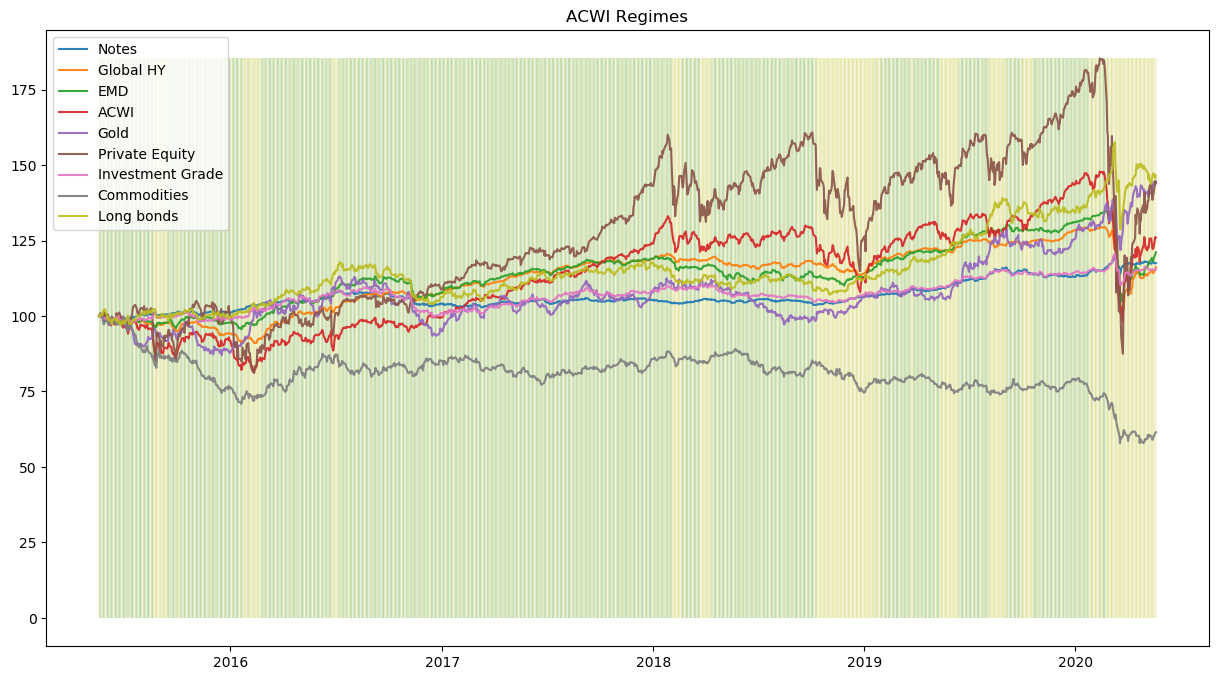

In [7]:
############# Line plot of index prices, background colored by regime ########################

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fig, ax = plt.subplots( figsize=(15,8) )

#Loop through all indices
for factor_price in df.loc[:, "Notes": "Long bonds"].columns:
    plt.plot(df.index , df[factor_price],
                label=factor_price, alpha = 20)

colors = ["yg","y"]

#ax.axvspan(start_train, end_test, alpha=0.5, color='white', zorder = 1)

for state,color in zip(df["states"].unique(), colors ):
    plot_area = df[df["states"] == state]
    plt.vlines(plot_area.index, ymin=df.min().min() , ymax = df.max().max(),
               alpha=0.1, color=color, ls="solid")
    

plt.title("ACWI Regimes")
plt.legend()
plt.show()

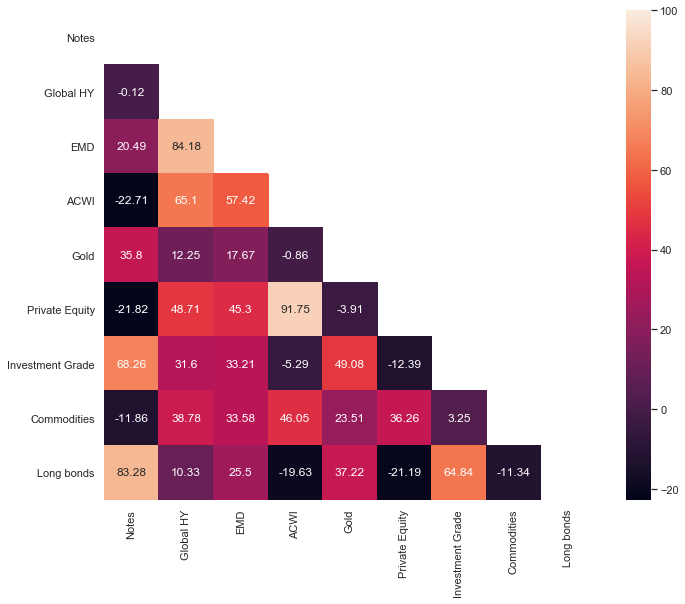

In [8]:
%matplotlib inline
import seaborn as sns
sns.set(style="white")


# Compute the correlation matrix
corr = (df_excess.loc[:, first_asset:last_asset].corr() * 100).round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, fmt="2g")

In [9]:
first_asset = "Notes"
last_asset = "Long bonds"

drop_list = ["Global HY", "Investment Grade", "Commodities"]

df_ret.drop(columns = drop_list, inplace = True)
df.drop(columns = drop_list, inplace = True)
df_excess.drop(columns = drop_list, inplace = True)

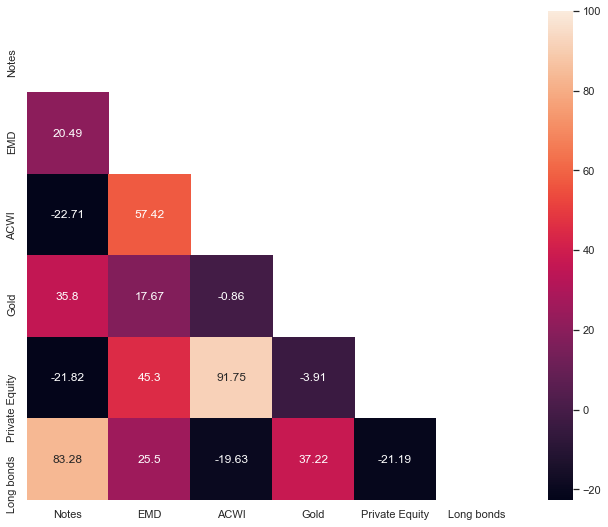

In [10]:
sns.set(style="white")

# Compute the correlation matrix
corr = (df_excess.loc[:, first_asset:last_asset].corr() * 100).round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, fmt="2g")

# Calculate tangency portfolios and draw frontier
Annualization formulas:
$$ \mu_{annual} = (1 + \mu_{daily})^{252} - 1 $$
$$ \sigma_{annual} = \sigma_{daily} * \sqrt{252} $$
$$ \Sigma_{annual} = \Sigma_{daily} * 252 $$

In [ ]:
def mean_var(df, analytical_tan = False, dynamic=True):
    '''
    Outputs the following variables:
    weight_state, mu, std, mu_tan ,std_tan, mu_mv, std_mv, mu_C, std_C
    '''
    
    df = df.copy() #So nothing is overwritten

    #Number of weights to use when drawing the frontier
    weights = np.linspace(-100,100, 1000)

    # Number of assets and states
    N_assets = len(df.loc[: , first_asset:last_asset].columns)
    N_states = len(df["states"].unique())

    # Empty arrays used to store information
    weight_state = np.zeros(shape = (N_states, N_assets) )
    mu = np.zeros(shape = (N_states, N_assets) )  # As many rows as states and as many columns as assets
    std = np.zeros(shape = (N_states, N_assets) )
    mu_tan = np.array([])
    std_tan = np.array([])
    mu_mv = np.array([])
    std_mv = np.array([])

    mu_C = np.zeros(shape = (N_states, len(weights)) )
    std_C = np.zeros(shape = (N_states, len(weights)) )

    # If static, all states are zero, and hence it does not groupby anything
    if dynamic == False:
        df["states"] = 0 

    for i,(state,data) in enumerate(df.groupby(by="states")):
        #Slice dataframe to only include risky assets
        data = data.loc[:,first_asset:last_asset] # Only include factor returns
        mu[i] = (1 + data.mean())**252 - 1   # Convert from daily to annualized returns
        std[i] = data.std() * np.sqrt(252) # Annualize daily standard deviations
        Sigma = (data.corr() * np.outer(std[i], std[i])).to_numpy()  #data.cov() * 252
        Sigma_inv = np.linalg.inv(Sigma)
        corr = data.loc[:, ["ACWI", "Notes", "EMD", "Private Equity", "Gold", "Long bonds"]].corr()

        #print("Average return for state", i)
        #display(pd.DataFrame(mu[i], index = df_excess.loc[:, first_asset:last_asset].columns, columns = ['State {}'.format(i)]).round(4))

        #print("Standard deviation for state", i)
        #display(pd.DataFrame(std[i], index = df_excess.loc[:, first_asset:last_asset].columns, columns = ['State {}'.format(i)]).round(4))

        #print("Correlation matrix")
        #display(pd.DataFrame(corr, index = df_excess.loc[:, ["ACWI", "Notes", "EMD", "Private Equity", "Gold", "Long bonds"]].columns, columns = df_excess.loc[:, ["ACWI", "Notes", "EMD", "Private Equity", "Gold", "Long bonds"]].columns).round(4))
        ones = np.ones(len(mu[i]))

        ### Compute Tangency portfolio #############

        #### NUMERICAL SOLUTION TO TANGENCY
        def target_fun(w):
            return  -(w.T.dot(mu[i]) / np.sqrt(w.T.dot(Sigma).dot(w)) )  #Maximize this

        cons = ({"type":"eq", "fun":lambda w: np.sum(w)-1}, #weights, sum to 1
               {"type":"ineq", "fun": lambda w: w}) 

        start_val = mu[i]/sum(mu[i])

        w_tan = opt.minimize(target_fun, x0=start_val,constraints=cons, options = {"disp":False,"maxiter":10000000}, tol=0.0000000000000000000001).x

        if analytical_tan:
            w_tan = (Sigma_inv.dot(mu[i]) ) / (ones.T.dot(Sigma_inv).dot(mu[i]))
            
        weight_state[i] = w_tan

        mu_tan = np.append(mu_tan , mu[i].dot(w_tan) )
        std_tan = np.append(std_tan , np.sqrt( w_tan.T.dot(Sigma).dot(w_tan) ) )
        #print("Tangency portfolio mean for state {} = {}".format(state, mu_tan))
        #print("Tangency portfolio std for state {} = {}".format(state, std_tan))

        #### Compute Minimum-Variance Portfolio #################
        def mv_fun(w):
            return  w.T.dot(Sigma).dot(w)  #Minimize this

        cons = ({"type":"eq", "fun":lambda w: np.sum(w)-1}, #weights, sum to 1
               {"type":"ineq", "fun": lambda w: w}) 

        start_val = mu[i]/sum(mu[i])

        w_mv = opt.minimize(mv_fun, x0=start_val,constraints=cons, options = {"disp":False,"maxiter":10000000}, tol=0.0000000000000000000001).x

        if analytical_tan:
            w_mv = Sigma_inv.dot(ones) / (ones.dot(Sigma_inv).dot(ones)) 
        
        mu_mv = np.append(mu_mv , mu[i].dot(w_mv) )
        std_mv = np.append(std_mv , np.sqrt( w_mv.T.dot(Sigma).dot(w_mv) ) )
        #print("Minimum variance portfolio mean for state {} = {}".format(state, mu_mv))
        #print("Minimum variance portfolio standard deviation for state {} = {}".format(state, std_mv))

        ####### Draw efficient frontier of risky assets using different combinations of mv and tan #######

        mu_list = []
        std_list = []

        for w in weights:
            w_c = w_mv * w + w_tan * (1-w)
            returns = mu[i].dot(w_c)
            risk = np.sqrt( w_c.T.dot(Sigma).dot(w_c) )

            mu_list.append(returns)
            std_list.append(risk)

        mu_C[i] = mu_list
        std_C[i] = std_list

    if dynamic == False:
        weight_state = weight_state[0]

    return weight_state, mu, std, mu_tan ,std_tan, mu_mv, std_mv, mu_C, std_C

print("Constrained")
weight_state_cons, mu, std, mu_tan ,std_tan, mu_mv, std_mv, mu_C, std_C = mean_var(df_excess, analytical_tan=False, dynamic=True)
print("\n")
print("Unconstrained")
weight_state, mu, std, mu_tan ,std_tan, mu_mv, std_mv, mu_C, std_C = mean_var(df_excess, analytical_tan=True, dynamic=True)

Constrained
Average return for state 0


,State 0
Notes,0.0239
EMD,0.0923
ACWI,0.1625
Gold,0.1032
Private Equity,0.2101
Long bonds,0.0850


Standard deviation for state 0


,State 0
Notes,0.0215
EMD,0.0464
ACWI,0.0951
Gold,0.1596
Private Equity,0.1785
Long bonds,0.0841


Correlation matrix


,ACWI,Notes,EMD,Private Equity,Gold,Long bonds
ACWI,1.0000,-0.1644,0.3741,0.7163,0.2314,-0.1863
Notes,-0.1644,1.0000,0.3623,-0.1327,0.1506,0.7265
EMD,0.3741,0.3623,1.0000,0.2312,0.1799,0.3309
Private Equity,0.7163,-0.1327,0.2312,1.0000,0.0519,-0.1788
Gold,0.2314,0.1506,0.1799,0.0519,1.0000,0.1154
Long bonds,-0.1863,0.7265,0.3309,-0.1788,0.1154,1.0000


Tangency portfolio mean for state 0 = [0.079860403]
Tangency portfolio std for state 0 = [0.0330454749]
Minimum variance portfolio mean for state 0 = [0.0347044269]
Minimum variance portfolio standard deviation for state 0 = [0.0199610075]
Average return for state 1


,State 1
Notes,0.0406
EMD,0.0778
ACWI,-0.1093
Gold,0.0951
Private Equity,0.0818
Long bonds,0.0558


Standard deviation for state 1


,State 1
Notes,0.0299
EMD,0.0950
ACWI,0.2268
Gold,0.2094
Private Equity,0.4053
Long bonds,0.1111


Correlation matrix


,ACWI,Notes,EMD,Private Equity,Gold,Long bonds
ACWI,1.0000,-0.4145,0.4473,0.4964,0.0681,-0.3264
Notes,-0.4145,1.0000,-0.0172,-0.2240,0.0942,0.7479
EMD,0.4473,-0.0172,1.0000,0.1861,0.1497,0.0589
Private Equity,0.4964,-0.2240,0.1861,1.0000,-0.1079,-0.1963
Gold,0.0681,0.0942,0.1497,-0.1079,1.0000,0.0743
Long bonds,-0.3264,0.7479,0.0589,-0.1963,0.0743,1.0000


Tangency portfolio mean for state 1 = [0.079860403  0.0474180998]
Tangency portfolio std for state 1 = [0.0330454749 0.0286119736]
Minimum variance portfolio mean for state 1 = [0.0347044269 0.0323817404]
Minimum variance portfolio standard deviation for state 1 = [0.0199610075 0.0256393243]


Unconstrained
Average return for state 0


,State 0
Notes,0.0239
EMD,0.0923
ACWI,0.1625
Gold,0.1032
Private Equity,0.2101
Long bonds,0.0850


Standard deviation for state 0


,State 0
Notes,0.0215
EMD,0.0464
ACWI,0.0951
Gold,0.1596
Private Equity,0.1785
Long bonds,0.0841


Correlation matrix


,ACWI,Notes,EMD,Private Equity,Gold,Long bonds
ACWI,1.0000,-0.1644,0.3741,0.7163,0.2314,-0.1863
Notes,-0.1644,1.0000,0.3623,-0.1327,0.1506,0.7265
EMD,0.3741,0.3623,1.0000,0.2312,0.1799,0.3309
Private Equity,0.7163,-0.1327,0.2312,1.0000,0.0519,-0.1788
Gold,0.2314,0.1506,0.1799,0.0519,1.0000,0.1154
Long bonds,-0.1863,0.7265,0.3309,-0.1788,0.1154,1.0000


Tangency portfolio mean for state 0 = [0.0796505933]
Tangency portfolio std for state 0 = [0.0329543636]
Minimum variance portfolio mean for state 0 = [0.0211174904]
Minimum variance portfolio standard deviation for state 0 = [0.0169683484]
Average return for state 1


,State 1
Notes,0.0406
EMD,0.0778
ACWI,-0.1093
Gold,0.0951
Private Equity,0.0818
Long bonds,0.0558


Standard deviation for state 1


,State 1
Notes,0.0299
EMD,0.0950
ACWI,0.2268
Gold,0.2094
Private Equity,0.4053
Long bonds,0.1111


Correlation matrix


,ACWI,Notes,EMD,Private Equity,Gold,Long bonds
ACWI,1.0000,-0.4145,0.4473,0.4964,0.0681,-0.3264
Notes,-0.4145,1.0000,-0.0172,-0.2240,0.0942,0.7479
EMD,0.4473,-0.0172,1.0000,0.1861,0.1497,0.0589
Private Equity,0.4964,-0.2240,0.1861,1.0000,-0.1079,-0.1963
Gold,0.0681,0.0942,0.1497,-0.1079,1.0000,0.0743
Long bonds,-0.3264,0.7479,0.0589,-0.1963,0.0743,1.0000


Tangency portfolio mean for state 1 = [0.0796505933 0.0555122929]
Tangency portfolio std for state 1 = [0.0329543636 0.0281208922]
Minimum variance portfolio mean for state 1 = [0.0211174904 0.0334992514]
Minimum variance portfolio standard deviation for state 1 = [0.0169683484 0.0218450007]


State =  0
mu tan =  0.07965059328059214
std tan =  0.032954363563950845
mu mv =  0.02111749036302412
std mv =  0.01696834843217497
State =  1
mu tan =  0.055512292865984095
std tan =  0.02812089218112542
mu mv =  0.033499251408258775
std mv =  0.02184500072739037


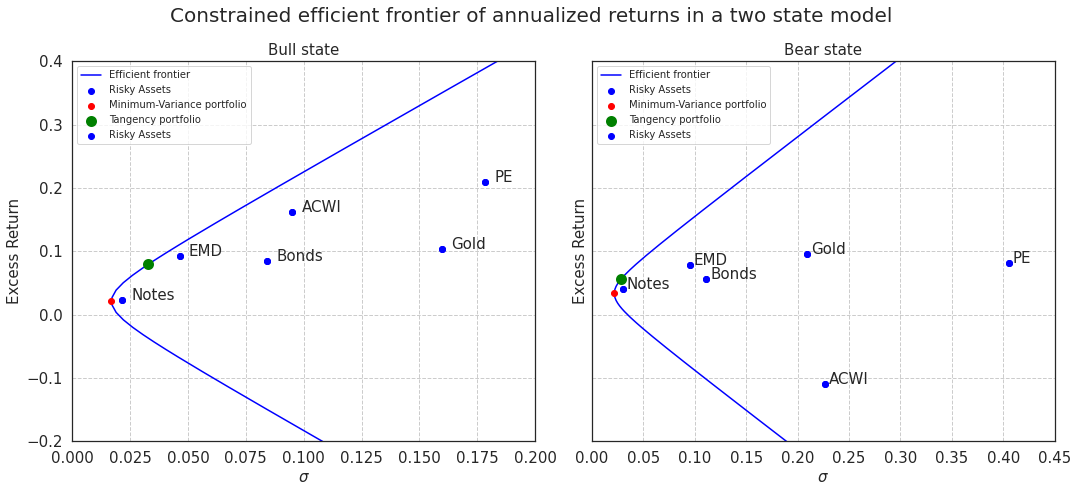

In [ ]:
fontsize = 15 # Set fontsize for all figures
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

# Create a 2x2 grid to plot in:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7), sharey = True)
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

#ax1 = plt.subplot2grid((1,2), (0,0))
#ax2 = plt.subplot2grid((1,2), (0,1))

labels = ["Notes", "EMD", "ACWI", "Gold", "PE", "Bonds"]

for i,axi in enumerate([ax1, ax2]):

    # plots
    axi.plot(std_C[i],mu_C[i], color="blue", label="Efficient frontier")
    #plt.plot(std_CML,mu_CML, color="green",linestyle="dotted", label="CML")

    #Scatter
    print("State = ", i)
    print("mu tan = ", mu_tan[i])
    print("std tan = ", std_tan[i])

    print("mu mv = ", mu_mv[i])
    print("std mv = ", std_mv[i])
    axi.scatter(std[i], mu[i], color="blue", zorder=5, label="Risky Assets")
    axi.scatter(std_mv[i], mu_mv[i], color="red", zorder=5, label="Minimum-Variance portfolio")
    axi.scatter(std_tan[i] , mu_tan[i], color="green", zorder=5, label="Tangency portfolio",lw=5)
    #axi.scatter(0, rf, color = "green", label="risk-free asset")
    #plt.scatter(std_p1,mu_p1,zorder=5,label="Port 1", lw=5)
    #plt.scatter(std_p2,mu_p2,zorder=5,label="Port 2", lw = 5)

    # labels, etc
    axi.set_xlabel('$\sigma$', size=15)
    axi.set_ylabel('Excess Return', size = 15)
    
    
    ax1.set_xlim(0.0,0.2)
    ax2.set_xlim(0.0,0.45)
    axi.set_ylim(-0.2,0.4)

    axi.legend()
    axi.grid(True, linestyle="--")

    #Scatter
    axi.scatter(std[i], mu[i], color="blue", zorder=5, label="Risky Assets")
    for j, txt in enumerate(labels):
        axi.annotate(txt, (std[i][j] + 0.004, mu[i][j]))  

    axi.legend(fontsize=10)  

# legend & title

ax1.set_title("Bull state")
ax2.set_title("Bear state")
ax1.text(1, 1.1, ' ', transform=ax1.transAxes, size=12, color='#777777') # Creates space for the title
fig.suptitle("Constrained efficient frontier of annualized returns in a two state model", size=20)

plt.tight_layout()
plt.show()

- Realistic borrowing constraints? 30x long in some assets
- Choice of risk-free asset?

## Calculating returns by each state

In this section we calculate returns by grouping all observations within each state every time a new state is chosen. I.e. every time the state changes we calculate the "sell" our current position and "buy" a new poisiton corresponding to the tangency portfolio in that state.

In [ ]:
def cagr(total_ret, N):
    return (1+total_ret)**(1/N)-1

# Get number of years in train & test - used for annualizing total returns
N_years_all = (dt.datetime.strptime(end_test, "%Y-%m-%d") - dt.datetime.strptime(start_train, "%Y-%m-%d")).days / 365
N_years_train = (dt.datetime.strptime(end_train, "%Y-%m-%d") - dt.datetime.strptime(start_train, "%Y-%m-%d")).days / 365
N_years_test = (dt.datetime.strptime(end_test, "%Y-%m-%d") - dt.datetime.strptime(start_test, "%Y-%m-%d")).days / 365

def trading_stats(df, weights, dynamic=True):
    df = df.copy()

    # Get the state lagged 1 variable
    # Then create a count column which tracks every time the state changes
    df["states lag 1"] =  df["states"].shift(1)
    df["states lag 1"].iloc[0] = 0

    df["states lag 2"] =  df["states"].shift(2)
    df["states lag 2"].iloc[0:2] = 0
    df["Count"] = df.apply(lambda x: x["states lag 1"] != x["states lag 2"] , axis=1).cumsum()

    #Groupby Count and calculate returns for all state changes.
    returns = np.array([])
    Sigma = np.array([])
    gross_ret = np.array([])

    for regime_change, data in df.groupby(by="Count"):

        # Get indicator for state
        state = int(data["states"].median())

        # Compute running weights
        if dynamic == True:
            w = weights[state]
        else:
            w = weights

        for idx in range(len(data)):
            gross_r = data.iloc[idx][first_asset:last_asset] + 1
           # display(gross_r)
            new_w = gross_r * w
            new_w = new_w / sum(new_w)

            #print(new_w.round(4))

            gross_tot = w.dot(gross_r)
            gross_ret = np.append(gross_ret , gross_tot)


            w = new_w # Update weights every iteration

    rebalance_cost = 0.0001 # 10 basis points
    rebalance_cost = (1-rebalance_cost)**(max(df["Count"]))
    df["Gross_ret"] = gross_ret

    # Compute returns after subtracting rebalancing costs
    def ret_after_cost(x):
        if x["states lag 1"] == x["states lag 2"]:
            return x["Gross_ret"]
        else:
            return x["Gross_ret"]* (1-0.0001)


    df["Gross_ret TC"] = df.apply(ret_after_cost , axis=1) # Subtract trading costs
    df["excess_ret"] = df["Gross_ret TC"] - df["rf"]

    def port_performance(df_ret, start, stop, N_years):  
        returns = df["Gross_ret TC"].loc[start:stop]
        total_r = returns.prod()-1
        annual_r = cagr(total_r, N_years)
        std = returns.std()*np.sqrt(252)

        print(N_years)

        #Sharpe
        excess_ret = df["excess_ret"].loc[start:stop]
        annual_excess = cagr(excess_ret.prod()-1, N_years)
        std = excess_ret.std()*np.sqrt(252)
        sharpe = annual_excess / std
        
        return total_r, annual_r, std, sharpe
    
    results_df = pd.DataFrame(index = ["Total Returns", "Annual return", "STD", "Sharpe"])

    results_df["All"] = list(port_performance(df_ret, start_train, end_test, N_years_all))
    results_df["Train"] = list(port_performance(df_ret, start_train, end_train, N_years_train))
    results_df["Test"] = list(port_performance(df_ret, start_test, end_test, N_years_test))
    
    return results_df

trading_stats(df_ret, weight_state, dynamic=True)

20.397260273972602
15.013698630136986
5.380821917808219


,All,Train,Test
Total Returns,2.1211805047,1.4273967198,0.2858139253
Annual return,0.0573884753,0.0608466851,0.0478285610
STD,0.0329274171,0.0323607176,0.0344692469
Sharpe,1.3763384294,1.4584605268,1.1639857293


# Strategic Asset Allocation
Same as above, except no states

Constrained
Average return for state 0


,State 0
Notes,0.0310
EMD,0.0861
ACWI,0.0373
Gold,0.0997
Private Equity,0.1534
Long bonds,0.0724


Standard deviation for state 0


,State 0
Notes,0.0254
EMD,0.0714
ACWI,0.1651
Gold,0.1826
Private Equity,0.2975
Long bonds,0.0966


Correlation matrix


,ACWI,Notes,EMD,Private Equity,Gold,Long bonds
ACWI,1.0000,-0.3334,0.4304,0.5397,0.1126,-0.2736
Notes,-0.3334,1.0000,0.1021,-0.1923,0.1179,0.7383
EMD,0.4304,0.1021,1.0000,0.1960,0.1563,0.1459
Private Equity,0.5397,-0.1923,0.1960,1.0000,-0.0565,-0.1849
Gold,0.1126,0.1179,0.1563,-0.0565,1.0000,0.0922
Long bonds,-0.2736,0.7383,0.1459,-0.1849,0.0922,1.0000


Tangency portfolio mean for state 0 = [0.0476766504]
Tangency portfolio std for state 0 = [0.027354761]
Minimum variance portfolio mean for state 0 = [0.0316163947]
Minimum variance portfolio standard deviation for state 0 = [0.0225984222]


Unconstrained
Average return for state 0


,State 0
Notes,0.0310
EMD,0.0861
ACWI,0.0373
Gold,0.0997
Private Equity,0.1534
Long bonds,0.0724


Standard deviation for state 0


,State 0
Notes,0.0254
EMD,0.0714
ACWI,0.1651
Gold,0.1826
Private Equity,0.2975
Long bonds,0.0966


Correlation matrix


,ACWI,Notes,EMD,Private Equity,Gold,Long bonds
ACWI,1.0000,-0.3334,0.4304,0.5397,0.1126,-0.2736
Notes,-0.3334,1.0000,0.1021,-0.1923,0.1179,0.7383
EMD,0.4304,0.1021,1.0000,0.1960,0.1563,0.1459
Private Equity,0.5397,-0.1923,0.1960,1.0000,-0.0565,-0.1849
Gold,0.1126,0.1179,0.1563,-0.0565,1.0000,0.0922
Long bonds,-0.2736,0.7383,0.1459,-0.1849,0.0922,1.0000


Tangency portfolio mean for state 0 = [0.0455413572]
Tangency portfolio std for state 0 = [0.0256391405]
Minimum variance portfolio mean for state 0 = [0.02567733]
Minimum variance portfolio standard deviation for state 0 = [0.0192519803]


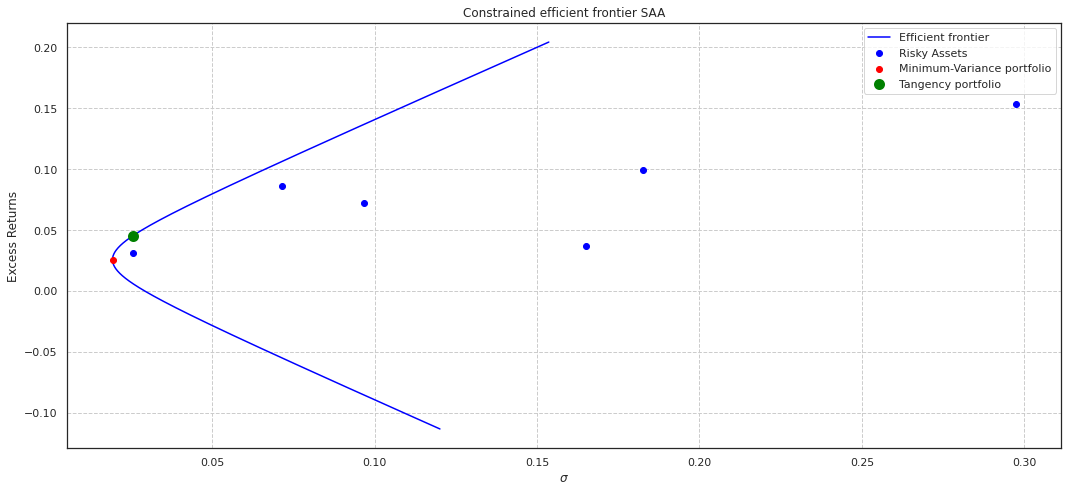

In [ ]:
print("Constrained")
weights_saa_cons, mu, std, mu_tan ,std_tan, mu_mv, std_mv, mu_C, std_C = mean_var(df_excess, analytical_tan=False, dynamic=False)

print("\n")
print("Unconstrained")
weights_saa, mu, std, mu_tan ,std_tan, mu_mv, std_mv, mu_C, std_C = mean_var(df_excess, analytical_tan=True, dynamic=False)

# Create a 2x2 grid to plot in:
fig, axi = plt.subplots(figsize=(15,7))
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

#ax1 = plt.subplot2grid((1,2), (0,0))
#ax2 = plt.subplot2grid((1,2), (0,1))

# plots
axi.plot(std_C[0],mu_C[0], color="blue", label="Efficient frontier")
#plt.plot(std_CML,mu_CML, color="green",linestyle="dotted", label="CML")

#Scatter
axi.scatter(std[0], mu[0], color="blue", zorder=5, label="Risky Assets")
axi.scatter(std_mv, mu_mv, color="red", zorder=5, label="Minimum-Variance portfolio")
axi.scatter(std_tan, mu_tan, color="green", zorder=5, label="Tangency portfolio",lw=5)
#axi.scatter(0, rf, color = "green", label="risk-free asset")
#plt.scatter(std_p1,mu_p1,zorder=5,label="Port 1", lw=5)
#plt.scatter(std_p2,mu_p2,zorder=5,label="Port 2", lw = 5)

# labels, etc
axi.set_xlabel('$\sigma$', size=12)
axi.set_ylabel('Excess Returns', size = 12)
axi.set_title("Constrained efficient frontier SAA")

axi.legend()
axi.grid(True, linestyle="--")
    

# legend & title
ax1.text(1, 1.1, ' ', transform=ax1.transAxes, size=12, color='#777777') # Creates space for the title

plt.tight_layout()
plt.show()

In [ ]:
# we want to rebalance on the first trading day of the year
def first_day_of_year(x):
    # we find the first trading day of the year
    first_day = 1
    first_trading_day = True
    while first_trading_day:
        if first_day == 10:
            print("too much")
            break
        try: 
            df_strategic['Date'].loc['{}-{}-{}'.format(x.year, '01', '0' + str(first_day))].year * 2
            first_trading_day = False
        except:
            first_day += 1

    if x.day == first_day and x.month == 1:
        return 1
    else:
        return 0

df_strategic = df_ret.copy()
df_strategic['Date'] = df_strategic.index
df_strategic['states'] = 0

# here we override the states with an indicator that shows every first trading day of the year
df_strategic['states'] = df_strategic['Date'].apply(first_day_of_year)

In [ ]:
trading_stats(df_ret, weight_state_cons, dynamic=True).round(4)

20.397260273972602
15.013698630136986
5.380821917808219


,All,Train,Test
Total Returns,2.0565,1.3531,0.2989
Annual return,0.0563,0.0587,0.0498
STD,0.0338,0.0328,0.0365
Sharpe,1.3089,1.3729,1.1539


In [ ]:
trading_stats(df_ret, weight_state, dynamic=True).round(4)

20.397260273972602
15.013698630136986
5.380821917808219


,All,Train,Test
Total Returns,2.1212,1.4274,0.2858
Annual return,0.0574,0.0608,0.0478
STD,0.0329,0.0324,0.0345
Sharpe,1.3763,1.4585,1.1640


In [ ]:
trading_stats(df_strategic, np.vstack([weights_saa_cons, weights_saa_cons]), dynamic = True).round(4)

20.397260273972602
15.013698630136986
5.380821917808219


,All,Train,Test
Total Returns,1.4649,1.0297,0.2144
Annual return,0.0452,0.0483,0.0368
STD,0.0283,0.0271,0.0314
Sharpe,1.1762,1.2834,0.9276


In [ ]:
  trading_stats(df_strategic, np.vstack([weights_saa, weights_saa]), dynamic = True).round(4)

20.397260273972602
15.013698630136986
5.380821917808219


,All,Train,Test
Total Returns,1.3511,0.9677,0.1948
Annual return,0.0428,0.0461,0.0336
STD,0.0262,0.0254,0.0284
Sharpe,1.1802,1.2877,0.9182


### Alternative strategies

100% stocks in low vol - 100% bonds in high vol

In [ ]:
trading_stats(df_ret, np.vstack([np.array([0, 0, 1, 0, 0, 0]), np.array([0, 0, 0, 0, 0, 1])]), dynamic=True).round(4)

20.397260273972602
15.013698630136986
5.380821917808219


,All,Train,Test
Total Returns,4.2462,2.3313,0.5748
Annual return,0.0847,0.0835,0.0881
STD,0.1079,0.1075,0.1088
Sharpe,0.6701,0.6464,0.7359


60% stocks and 40% bonds

In [ ]:
trading_stats(df_strategic, np.vstack([np.array([0.40, 0, 0.60, 0, 0, 0]), np.array([0.40, 0, 0.60, 0, 0, 0])]), dynamic = True).round(4)

20.397260273972602
15.013698630136986
5.380821917808219


,All,Train,Test
Total Returns,1.1258,0.6420,0.2946
Annual return,0.0377,0.0336,0.0492
STD,0.0881,0.0897,0.0834
Sharpe,0.2932,0.2261,0.4972


Only stocks

In [ ]:
trading_stats(df_strategic, np.vstack([np.array([0, 0, 1, 0, 0, 0]), np.array([0, 0, 1, 0, 0, 0])]), dynamic=True).round(4)

20.397260273972602
15.013698630136986
5.380821917808219


,All,Train,Test
Total Returns,0.9178,0.4251,0.3457
Annual return,0.0324,0.0239,0.0567
STD,0.1611,0.1651,0.1494
Sharpe,0.1282,0.0648,0.3277


Only bonds

In [ ]:
trading_stats(df_strategic, np.vstack([np.array([1, 0, 0, 0, 0, 0]), np.array([1, 0, 0, 0, 0, 0])]), dynamic=True).round(4)

20.397260273972602
15.013698630136986
5.380821917808219


,All,Train,Test
Total Returns,0.8744,0.5938,0.1761
Annual return,0.0313,0.0315,0.0306
STD,0.0270,0.0255,0.0309
Sharpe,0.7222,0.7163,0.7454


# Comparison

In [ ]:
# Dataframe for saving portfolio weights - printed in Strategic Allocation section
print("Unconstrained weights")
port_weights = pd.DataFrame(weight_state, columns=df_ret.loc[: , first_asset:last_asset].columns, index=["State 0", "State 1"]).T.round(4)
port_weights["Static"] = weights_saa
port_weights.round(6).loc[["ACWI", "Notes", "EMD", "Private Equity", "Gold", "Long bonds"]]

Unconstrained weights


,State 0,State 1,Static
ACWI,0.2155,-0.0586,-0.023246
Notes,0.4015,1.0090,0.818843
EMD,0.3022,0.1764,0.214118
Private Equity,0.0029,0.0243,0.032226
Gold,-0.0035,0.0215,0.025265
Long bonds,0.0814,-0.1726,-0.067205


In [ ]:
print("Constrained portfolios")
port_weights = pd.DataFrame(weight_state_cons, columns=df_ret.loc[: , first_asset:last_asset].columns, index=["State 0", "State 1"]).T.round(4)
port_weights["Static"] = weights_saa_cons
port_weights.round(4).loc[["ACWI", "Notes", "EMD", "Private Equity", "Gold", "Long bonds"]]

Constrained portfolios


,State 0,State 1,Static
ACWI,0.2136,-0.0000,0.0000
Notes,0.3982,0.8289,0.7410
EMD,0.3031,0.1324,0.2031
Private Equity,0.0036,0.0177,0.0307
Gold,0.0000,0.0210,0.0252
Long bonds,0.0814,-0.0000,0.0000
